In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
import SimpleITK as sitk

In [2]:
"""
Function used to normalize the
the input image using Z-score
normalization
"""
def normalizeImage(iImage):
    return (iImage - np.mean(iImage)) / np.std(iImage)

"""
Generate a test image (chess board)
"""
def getChessBoardImage(iImageSize, iArraySieze = 10, dtype = 'uint'):
    """Get the step size"""
    dx = int(np.ceil(iImageSize[0] / iArraySieze)) + 1
    dy = int(np.ceil(iImageSize[1] / iArraySieze)) + 1

    xy = [
        255 * np.ones(shape=(iArraySieze, iArraySieze)),
        np.zeros(shape=(iArraySieze, iArraySieze))
    ]

    """
    vstack stacks arrays vertically (row-wise), meaning it combines arrays along a new first axis.
    hstack stacks arrays horizontally (column-wise), combining arrays along the second axis
    """
    board = np.array(
        np.vstack([
            np.hstack([xy[(i + j) % 2] \
                       for i in range(dx)]) \
            for j in range(dy)
        ]), dtype=dtype
    )

    return board[:iImageSize[0], :iImageSize[1]]

"""
Helper function for defining the deformation
"""
def swirlControlPoints(iCPx, iCPy, a=2.0, b=100.0):
    oCPx = np.array(iCPx)
    oCPy = np.array(iCPy)
    xc = np.mean(oCPx[1:-3,1:-3])
    yc = np.mean(oCPy[1:-3,1:-3])
    rx1 = oCPx[1:-3,1:-3] - xc
    ry1 = oCPy[1:-3,1:-3] - yc
    angle = a*np.exp(-(rx1*rx1+ry1*ry1)/(b*b))
    oCPx[1:-3,1:-3] = np.cos(angle)*rx1 + np.sin(angle)*ry1 + xc
    oCPy[1:-3,1:-3] = -np.sin(angle)*rx1 + np.cos(angle)*ry1 + xc
    return oCPx, oCPy

In [3]:
"""
B-splines
"""
def B0(u):
    return (1 - u)**3 / 6

def B1(u):
    return (3*u**3 - 6*u**2 + 4) / 6

def B2(u):
    return (-3*u**3 + 3*u**2 + 3*u + 1) / 6

def B3(u):
    return u**3 / 6

B = np.array([B0, B1, B2, B3])

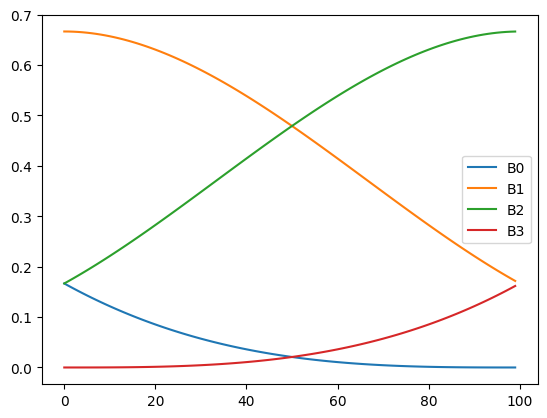

In [4]:
"""
Testing the B-spline functions
"""

data = []
for x in np.arange(0, 1, 0.01):
    data.append([Bt(x) for Bt in B])

data = np.array(data)

plt.figure()
plt.plot(data)
plt.legend(['B0', 'B1', 'B2', 'B3'])
plt.show()

In [43]:
"""
Function that creates a 2D grid of control points
"""
def getCubicBSpline2DGrid(iImageSize, iStep):

    if not isinstance(iStep, (list, tuple)):
        iStep = (iStep, iStep)

    oCpX, oCpY = np.meshgrid(
        np.arange(-iStep[0], np.ceil(iImageSize[0] / iStep[0] + 3) * iStep[0], iStep[0]),
        np.arange(-iStep[1], np.ceil(iImageSize[1] / iStep[1] + 3) * iStep[1], iStep[1])
    )

    return oCpX, oCpY

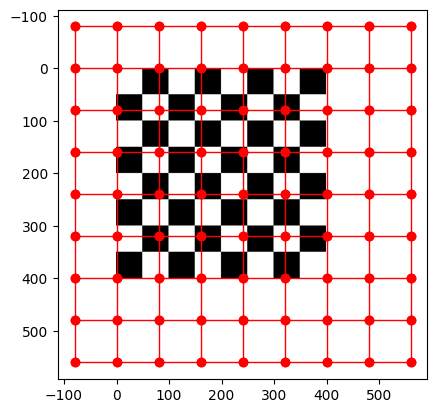

In [44]:
"""
Test the functions
"""
imageSize = (400, 400)
step = (80, 80)

board = getChessBoardImage(imageSize, 50)
cX, cY = getCubicBSpline2DGrid(imageSize, step)

plt.figure()
plt.imshow(board, cmap='gray')
plt.plot(cX, cY, marker='o', color='r', linewidth=1)
plt.plot(cX.transpose(), cY.transpose(), marker='o', color='r', linewidth=1)
plt.show()

In [64]:
"""
Function that calculates the deforamtion field
"""
def getCubicBSpline2DDeformation(iImageSize, iCPx, iCPy, iStep):
    dx, dy = iImageSize
    gx, gy = np.meshgrid(
        np.arange(dx),
        np.arange(dy)
    )
    gx = np.array(gx, dtype='float64')
    gy = np.array(gy, dtype='float64')
    oGx = np.zeros_like(gx)
    oGy = np.zeros_like(gy)
    # Get the index of teh nearest control point
    i = np.floor(gx / iStep[0])
    j = np.floor(gy / iStep[1])
    # Exact location of the pixel within the cell
    u = (gx / iStep[0]) - i
    v = (gy / iStep[1]) - j
    for l in range(4):
        for m in range(4):
            oGx += B[l](u) * B[m](v)*iCPx[
                np.array(j, dtype='int64') + m,
                np.array(i, dtype='int64') + l
            ]
            oGy += B[l](u) * B[m](v)*iCPy[
                np.array(j, dtype='int64') + m,
                np.array(i, dtype='int64') + l
            ]

    return  oGx, oGy

Text(0.5, 1.0, 'Y shift')

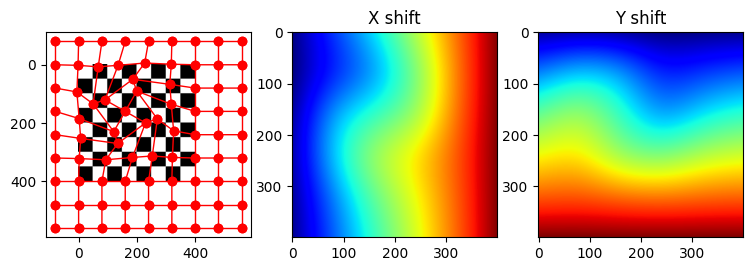

In [65]:
# Shift the control points
oCPx_swirl, oCPy_swirl = swirlControlPoints(cX, cY, a=2.0, b=100.0)

# Calculate the deformation
oGx, oGy = getCubicBSpline2DDeformation(
    board.shape, oCPx_swirl, oCPy_swirl, step)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
ax1.imshow(board, cmap='gray')
ax1.plot(oCPx_swirl, oCPy_swirl, marker='o', color='r', linewidth=1)
ax1.plot(oCPx_swirl.transpose(), oCPy_swirl.transpose(), marker='o',
         color='r', linewidth=1)
ax2.imshow(oGx, cmap='jet')
ax2.set_title('X shift')
ax3.imshow(oGy, cmap='jet')
ax3.set_title('Y shift')

In [66]:
"""
Deform and interpolate image
"""
def deformImageBSpline2D(iImage, iCPx, iCPy, iStep):
    dx, dy = iImage.shape
    oGx, oGy = getCubicBSpline2DDeformation(iImage.shape, iCPx, iCPy, iStep)
    gx, gy = np.meshgrid(
        np.arange(dx),
        np.arange(dy)
    )
    oGx = 2*gx - oGx
    oGy = 2*gy - oGy

    oImage = interpn(
        (np.arange(dy), np.arange(dx)),
        iImage.astype('float64'),
        np.dstack((oGy, oGx)),
        method='linear',
        bounds_error=False,
        fill_value=0
    )

    return  oImage

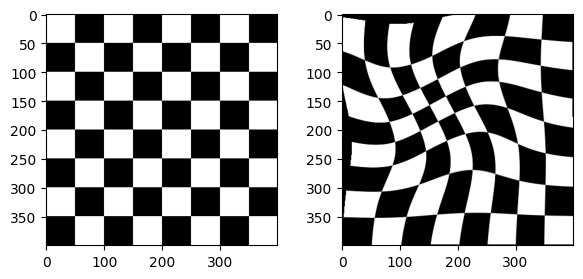

In [67]:
deformedBoard = deformImageBSpline2D(board, oCPx_swirl, oCPy_swirl, step)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.imshow(board, cmap='gray')
ax2.imshow(deformedBoard, cmap='gray')
plt.show()